In [1]:
#Блок в рамках которого импотряться математические подсчеты, падас и нампай
import pandas as pd
import numpy as np
from scipy.stats import iqr
from scipy import stats
from scipy.stats import skew
from scipy.stats import kurtosis
import scipy.stats
import scipy as sp
import scipy.stats as stats
from scipy.stats import t

#Блок в рамках которого импотряться графики
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns 
from matplotlib.pyplot import figure
sns.set_style('darkgrid')

#Блок в рамках которого импотряться статистические пакеты
import statsmodels.api as sm 
import statsmodels.formula.api as smf 
from sklearn.preprocessing import OneHotEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from statsmodels.regression.linear_model import OLS
from sklearn.decomposition import PCA
from statsmodels.stats.diagnostic import het_white, het_goldfeldquandt, het_breuschpagan
from statsmodels.stats.outliers_influence import reset_ramsey
from statsmodels.stats.diagnostic import compare_encompassing 

#Блок в рамках которого импотряться операционные пакеты
import os


# Содержание работы
0. [Предварительный EDA](#subparagraph0) - Начало анализ данных
1. [Обработка данных](#subparagraph1) 
2. [EDA](#subparagraph2) - Продолжение разведочного анализ данных 
3. [Multicollinearity](#subparagraph3) - Решение проблемы мультиколлинеарности (VIF)
4. [Heteroskedasticity](#subparagraph4) - Решение проблемы гетероскедастичности (Тест Уйта, Голдфелда—Куандта, Бройша—Пагана)
5. [Спецификация модели](#subparagraph5) - Выбор правильной спецификации модели (Тест Рамсея)
6. [Функциональная форма](#subparagraph6) - Выбор правильной функциональной формы (PE тест,  Харке-Бера)

### 0. Предварительный EDA <a name="subparagraph0"></a>

In [4]:
cd "C:\Users\Alexandr\Documents\GitHub\smartphone-price-analysis\"

C:\Users\Alexandr\Documents\GitHub\smartphone-price-analysis


In [3]:
# making "directoryback"
os.chdir(os.path.normpath(os.getcwd() + os.sep + os.pardir))

In [5]:
data = pd.read_csv('Data/PhonesDF_years.csv')
data.sample(3)

,phone_title,price,rating,specs_score,likes,disp_diag,camera,storage,ram,battery_capacity,battery_type,disp_height,disp_width,oper_syst_type,oper_syst_vers,brand,year_of_release
453,Infinix Hot 9 Play 2GB/32GB,849.0,5.0,54,5,6.82,8.0,32.0,2.0,6000.0,Li-Po,1640.0,720.0,Android,9,Infinix,2020
18,Samsung Galaxy Note 10 Lite 6GB/128GB,43999.0,3.8,73,26,6.70,32.0,128.0,6.0,4500.0,Li-Po,2400.0,1080.0,Android,10,Samsung,2020
255,Oppo K7 5G 8GB/128GB,699.0,5.0,100,9,6.40,32.0,128.0,8.0,4025.0,Li-Po,2400.0,1080.0,Android,10,Oppo,2020


In [6]:
# adding log price and PPI to dataset
data['log_price'] = np.log(data.price)
data['density'] = data.disp_height * data.disp_width / data.disp_diag**2

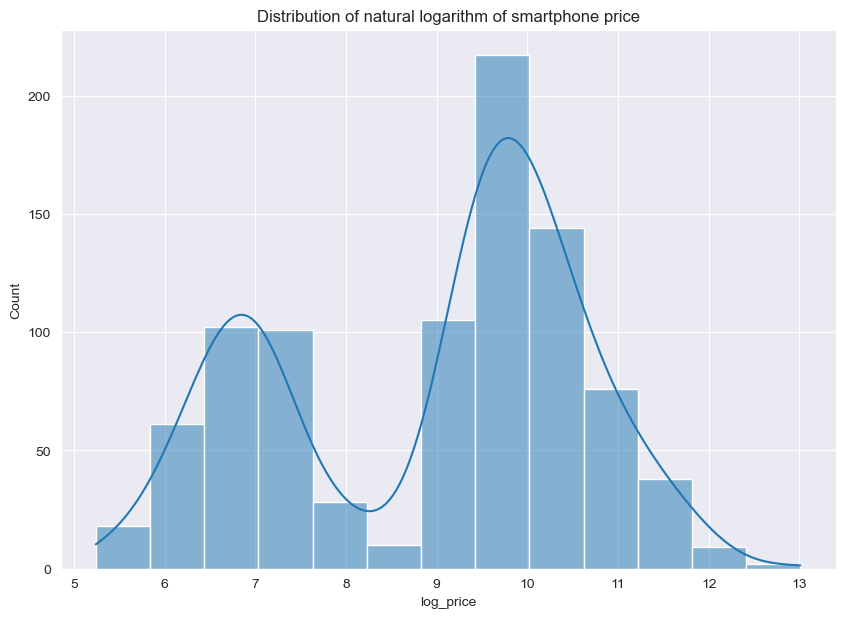

In [7]:
fig, ax = plt.subplots(figsize=(10, 7))
sns.histplot(data=data, x='log_price', ax=ax,  kde=True)
ax.set_title('Distribution of natural logarithm of smartphone price');

Видно, что у нас получилось бимодальное распределение, где каждый колокол напомоминает нормальное распределение. Скорее всего, это связано с тем, что у нас в датасете есть много некорректно указанных цен (ошибка с порядком цены), так как в левой части распределения телефоны имеют цену ниже 2000 рублей, что выглядит неправдоподобно.

Избавимся от этих выбросов и построим новое распределение цены:

In [8]:
# correcting and saving data
data = data.loc[(data.price >= np.exp(8.3)) & (data.price < np.exp(12.5)), :].copy(deep=True)
data.to_csv('Data/PhonesDF_years_corrected.csv', index=False)

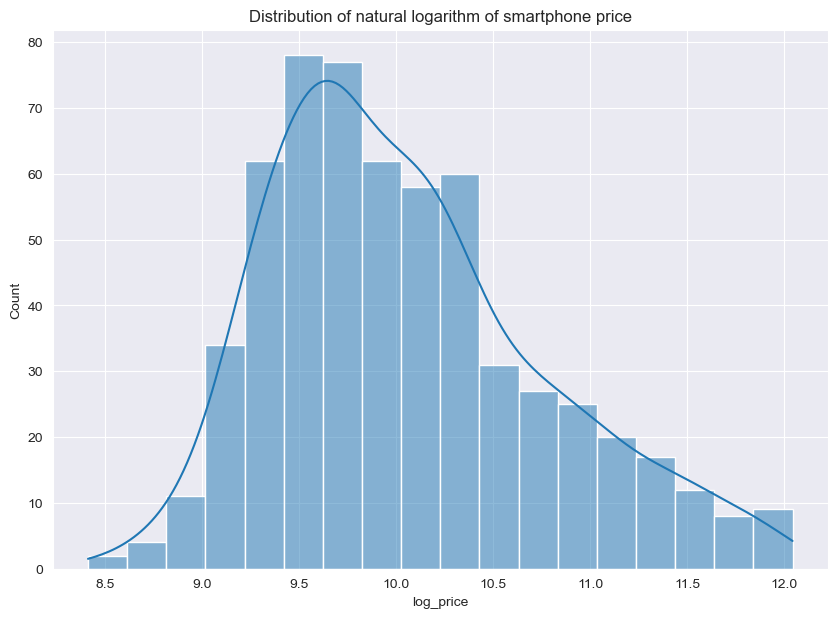

In [9]:
fig, ax = plt.subplots(figsize=(10, 7))
sns.histplot(data=data, x='log_price', ax=ax,  kde=True)
ax.set_title('Distribution of natural logarithm of smartphone price');

Видно, что распределение логарифма цены имеет правостороннюю ассиметрию.

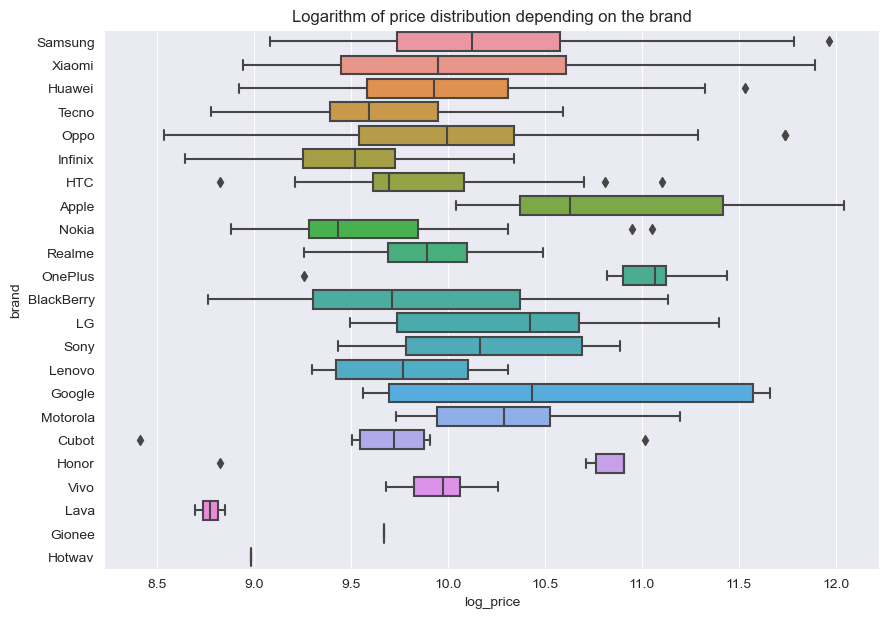

In [10]:
fig, ax = plt.subplots(figsize=(10, 7))
sns.boxplot(data=data, y='brand', x='log_price', ax=ax, order=list(data.brand.value_counts().index))
ax.set_title('Logarithm of price distribution depending on the brand');

Видно, что айфоны и смартфоны бренда Google сущестсвенно дороже, чем остальные.

Построим, как цена и ее логарифм зависит от числовых характеристик смартфона.

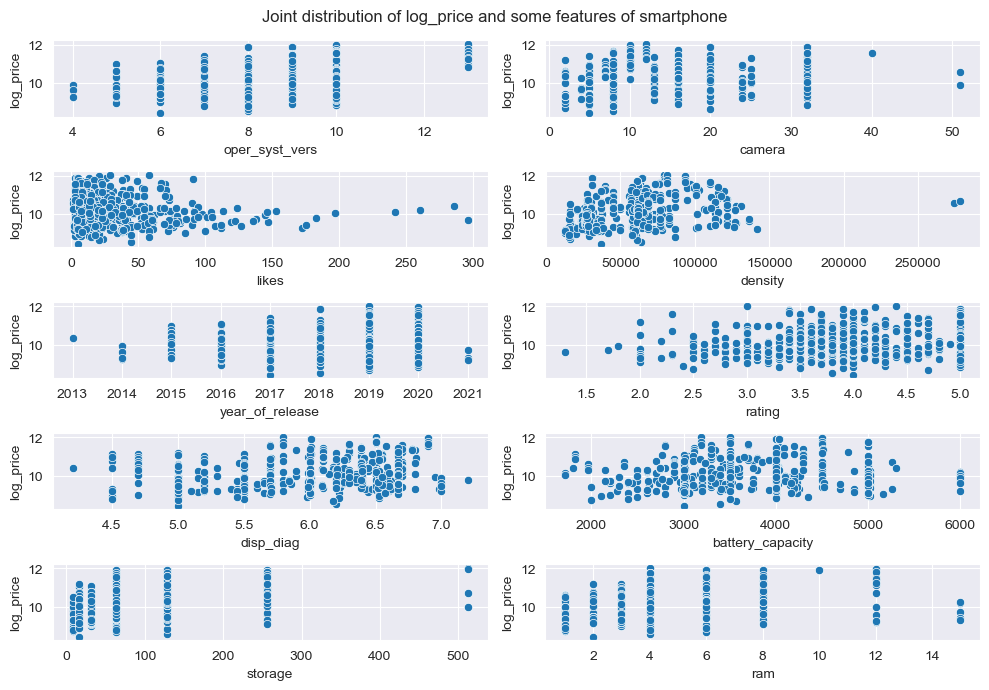

In [11]:
num_cols = list(set(list(data.select_dtypes([int, float]).columns)) - {'log_price', 'price', 'disp_width', 'disp_height', 'specs_score'})
fig, ax = plt.subplots(ncols=2, nrows=5, figsize=(10, 7))
for i, col in enumerate(num_cols):
    sns.scatterplot(data=data, x=col, y='log_price', ax=ax[i // 2][i % 2])
fig.suptitle('Joint distribution of log_price and some features of smartphone')
plt.tight_layout();

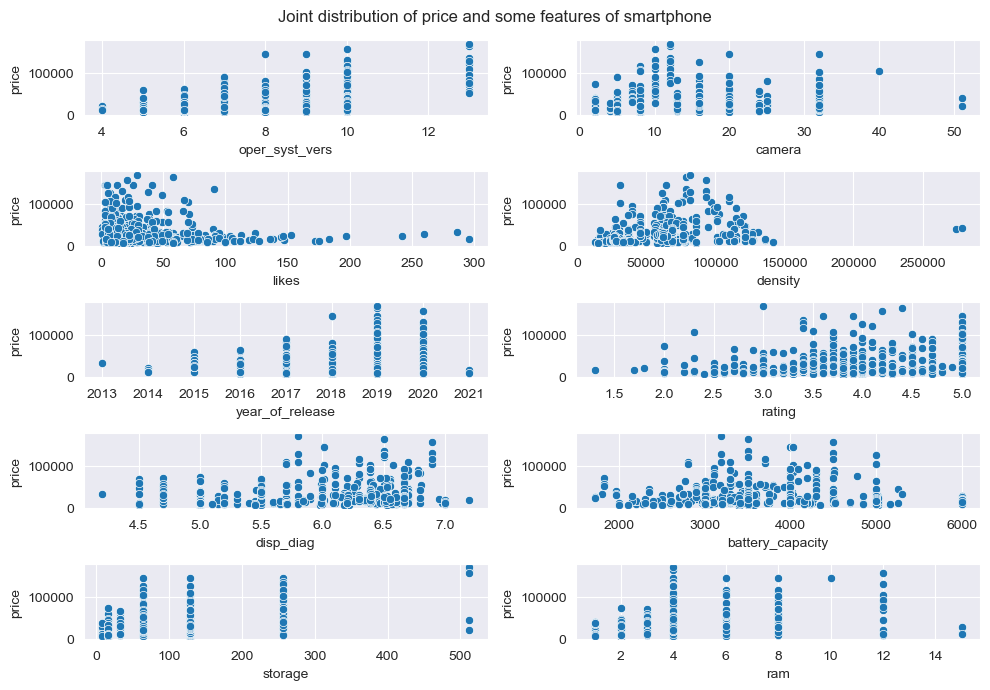

In [12]:
num_cols = list(set(list(data.select_dtypes([int, float]).columns)) - {'log_price', 'price', 'disp_width', 'disp_height', 'specs_score'})
fig, ax = plt.subplots(ncols=2, nrows=5, figsize=(10, 7))
for i, col in enumerate(num_cols):
    sns.scatterplot(data=data, x=col, y='price', ax=ax[i // 2][i % 2])
fig.suptitle('Joint distribution of price and some features of smartphone')
plt.tight_layout();

Таким образом, явной линейной и логлинейной звисимости тут не прослеживается. Попробуем отлогарифмировать признаки.

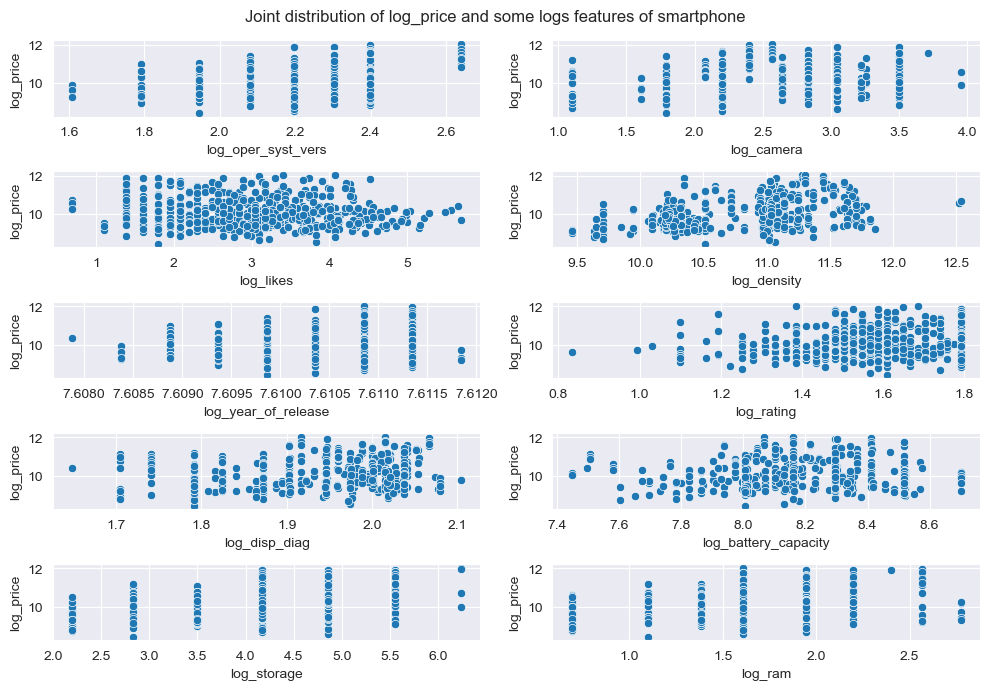

In [13]:
num_cols = list(set(list(data.select_dtypes([int, float]).columns)) - {'log_price', 'price', 'disp_width', 'disp_height', 'specs_score'})
fig, ax = plt.subplots(ncols=2, nrows=5, figsize=(10, 7))
for i, col in enumerate(num_cols):
    ax_cur = ax[i // 2][i % 2]
    sns.scatterplot(x=np.log1p(data[col]), y=data.log_price, ax=ax_cur)
    ax_cur.set_xlabel('log_' + col)
    ax_cur.set_ylabel('log_price')
fig.suptitle('Joint distribution of log_price and some logs features of smartphone')
plt.tight_layout();

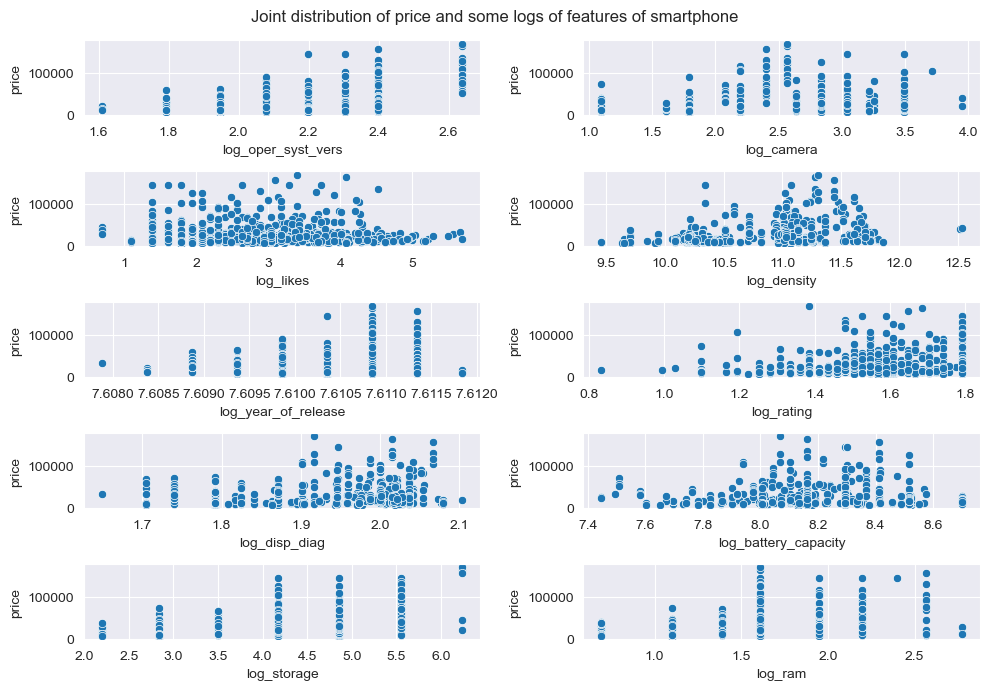

In [14]:
num_cols = list(set(list(data.select_dtypes([int, float]).columns)) - {'log_price', 'price', 'disp_width', 'disp_height', 'specs_score'})
fig, ax = plt.subplots(ncols=2, nrows=5, figsize=(10, 7))
for i, col in enumerate(num_cols):
    ax_cur = ax[i // 2][i % 2]
    sns.scatterplot(x=np.log1p(data[col]), y=data.price, ax=ax_cur)
    ax_cur.set_xlabel('log_' + col)
    ax_cur.set_ylabel('price')
fig.suptitle('Joint distribution of price and some logs of features of smartphone')
plt.tight_layout();

Явных зависимостей тоже не видно, но это всего лишь проекция данных на 2 оси, так что не стоит отчаиваться!

Посмотрим на корреляции 

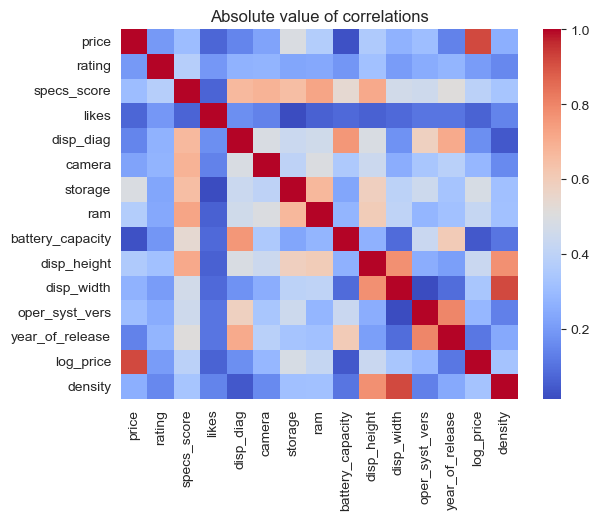

In [15]:
sns.heatmap(np.abs(data.corr()), cmap="coolwarm")
plt.title('Absolute value of correlations');

### 1. Обработка данных <a name="subparagraph1"></a>

In [16]:
data.sample(3)
data = data.drop(columns = ['price', 'specs_score'])

In [17]:
def encode_and_bind(original_dataframe, feature_to_encode, drop=True, drop_cat=None):
    if drop_cat == None:
        dummies = pd.get_dummies(original_dataframe[[feature_to_encode]], drop_first = drop)
    else:
        dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
        dummies.drop(columns=feature_to_encode + '_' + drop_cat, inplace=True)
    res = pd.concat([original_dataframe, dummies], axis=1)
    res = res.drop(columns = [feature_to_encode])
    return(res)

In [18]:
# # данные для вывода в отчете
# data = data.set_index('phone_title')
# data['Other_oper_syst'] = 0
# data['IOS_oper_syst'] = 0

# data.loc[data['oper_syst_type'] == 'Other', 'Other_oper_syst'] = 1 # Android - base dummy
# data.loc[data['oper_syst_type'] == 'IOS', 'IOS_oper_syst'] = 1 
# data = data.drop(columns = ['oper_syst_type', 'likes'])

# data = encode_and_bind(data, 'battery_type', drop=False)
# data = encode_and_bind(data, 'brand', drop=False)
# data = data.rename(columns = {'battery_type_ Li-Po':'battery_type_LiPo', 'battery_type_ Li-Ion':'battery_type_LiIon'})
# data = data[data['brand_Hotwav'] != 1]
# data = data.drop(columns = ['brand_Hotwav'])

# data.to_csv('PhonesDFUndropped.csv', index=False)

In [19]:
data = data.set_index('phone_title')

In [20]:
#Encode 'oper_syst_type'
data['Other_oper_syst'] = 0
data['IOS_oper_syst'] = 0

data.loc[data['oper_syst_type'] == 'Other', 'Other_oper_syst'] = 1 # Android - base dummy
data.loc[data['oper_syst_type'] == 'IOS', 'IOS_oper_syst'] = 1 
data = data.drop(columns = ['oper_syst_type', 'likes'])

#Encode 'battery_type' and 'brand'
data = encode_and_bind(data, 'battery_type')
data = encode_and_bind(data, 'brand', drop_cat='Xiaomi')
data = data.rename(columns = {'battery_type_ Li-Po':'battery_type_LiPo'})

In [21]:
data.sample(3)

,rating,disp_diag,camera,storage,ram,battery_capacity,disp_height,disp_width,oper_syst_vers,year_of_release,...,brand_Lenovo,brand_Motorola,brand_Nokia,brand_OnePlus,brand_Oppo,brand_Realme,brand_Samsung,brand_Sony,brand_Tecno,brand_Vivo
phone_title,,,,,,,,,,,,,,,,,,,,,
Xiaomi Mi Max 128 GB,3.0,6.44,5.0,128.0,4.0,4850.0,1920.0,1080.0,6,2016,...,0,0,0,0,0,0,0,0,0,0
Vivo Y19 8GB/128GB,2.7,6.53,16.0,128.0,8.0,5000.0,2340.0,1080.0,9,2019,...,0,0,0,0,0,0,0,0,0,1
Xiaomi Redmi 4a 16 GB,2.0,5.00,5.0,16.0,2.0,3120.0,1280.0,720.0,6,2016,...,0,0,0,0,0,0,0,0,0,0


In [22]:
# Dropping outlier
X_columns = data.drop(columns=['log_price', 'IOS_oper_syst', 'oper_syst_vers', 'disp_height', 'disp_width']).columns

ols = smf.ols(f"log_price ~ {' + '.join(map(str, X_columns))}", data=data).fit()

n = data.shape[0]
k = X_columns.shape[0] + 1
t_crit_r = t.ppf(0.975, n - k - 1)
t_crit_l = -t_crit_r
resid_std = ols.outlier_test()['student_resid']
mask = (resid_std < t_crit_r) & (resid_std > t_crit_l)

data = data[mask]

In [23]:
data = data[data['brand_Hotwav'] != 1]
data = data.drop(columns = ['brand_Hotwav'])

* Дамми-инкодинг категориальной переменной операционные системы ('oper_syst_type'), где базовая переменная 'Android'.В дальнейшем заметим, что 'IOS' и 'brend Apple' имеют полную мультиколлинеарность из-за необходимо будет убрать признак 'IOS'.
* Дамми-инкодинг категориальной переменной операционные системы ('battery_type')
* Удаление выбросов на основ естюдентизированных остатков, включая единственной наблюдение бренда 'brand_Hotwav'

### 2. EDA <a name="subparagraph2"></a>

In [24]:
np.round(data.describe(), 2)

,rating,disp_diag,camera,storage,ram,battery_capacity,disp_height,disp_width,oper_syst_vers,year_of_release,...,brand_Lenovo,brand_Motorola,brand_Nokia,brand_OnePlus,brand_Oppo,brand_Realme,brand_Samsung,brand_Sony,brand_Tecno,brand_Vivo
count,559.00,559.00,559.00,559.00,559.00,559.00,559.00,559.00,559.00,559.00,...,559.00,559.00,559.00,559.00,559.00,559.00,559.00,559.00,559.00,559.00
mean,3.84,6.01,13.05,83.18,4.46,3756.70,1969.14,986.75,8.44,2018.26,...,0.02,0.01,0.04,0.03,0.05,0.03,0.18,0.02,0.08,0.01
std,0.75,0.59,8.65,77.04,2.56,864.52,555.54,277.86,1.62,1.54,...,0.14,0.10,0.19,0.17,0.23,0.18,0.39,0.15,0.27,0.09
min,1.30,4.20,2.00,8.00,1.00,1715.00,480.00,480.00,4.00,2013.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,3.30,5.50,7.00,32.00,3.00,3020.00,1520.00,720.00,7.00,2017.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,3.80,6.20,10.00,64.00,4.00,4000.00,1920.00,1080.00,9.00,2019.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,4.40,6.50,16.00,128.00,6.00,4200.00,2340.00,1080.00,10.00,2019.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,5.00,7.20,51.00,512.00,15.00,6000.00,3840.00,3840.00,13.00,2021.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [25]:
def mean_mode_median(dataframe: pd.DataFrame) -> pd.DataFrame:
    '''
    Function for finding mean median and mode of continious data
    '''
    df = pd.DataFrame()
    df['Mode'] = stats.mode(dataframe)[0][0]
    df['Median'] = np.median(dataframe, axis=0)
    df['Mean'] = np.mean(dataframe, axis=0).to_numpy()
    
    df = np.round(df, 2)
    
    df.index = dataframe.columns
    return df

In [26]:
mean_mode_median(data)

,Mode,Median,Mean
rating,5.00,3.80,3.84
disp_diag,5.50,6.20,6.01
camera,8.00,10.00,13.05
storage,128.00,64.00,83.18
ram,4.00,4.00,4.46
battery_capacity,4000.00,4000.00,3756.70
disp_height,2340.00,1920.00,1969.14
disp_width,1080.00,1080.00,986.75
oper_syst_vers,9.00,9.00,8.44
year_of_release,2019.00,2019.00,2018.26


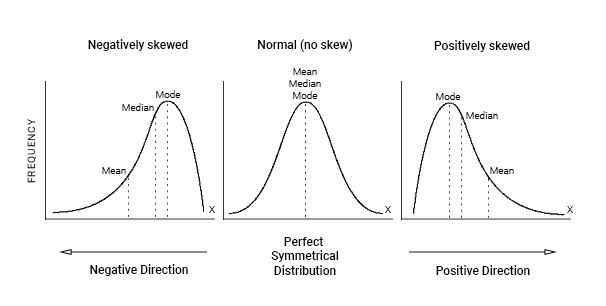

* Вывод описательной статистики данных для каждой перменной
* Вывод значений распределения моды, медианы, среднее для распределения каждой из переменной

### 3. Multicollinearity

In [27]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

data_m = add_constant(data)
data_m = data_m.drop(columns = ['log_price'])
pd.Series([variance_inflation_factor(data_m.values, i) 
               for i in range(data_m.shape[1])], 
              index=data_m.columns)


C:\Users\Alexandr\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


const                2.209831e+07
rating               1.315526e+00
disp_diag            9.344460e+00
camera               1.774994e+00
storage              2.502059e+00
ram                  2.542230e+00
battery_capacity     3.471707e+00
disp_height          1.631460e+01
disp_width           1.240436e+01
oper_syst_vers       1.661566e+01
year_of_release      1.287279e+01
density              2.944869e+01
Other_oper_syst      2.124472e+00
IOS_oper_syst                 inf
battery_type_LiPo    1.956227e+00
brand_Apple                   inf
brand_BlackBerry     1.591366e+00
brand_Cubot          1.110716e+00
brand_Gionee         1.043724e+00
brand_Google         1.352768e+00
brand_HTC            1.511002e+00
brand_Honor          1.082328e+00
brand_Huawei         1.805694e+00
brand_Infinix        1.514277e+00
brand_LG             1.281598e+00
brand_Lava           1.098696e+00
brand_Lenovo         1.197391e+00
brand_Motorola       1.133971e+00
brand_Nokia          1.438695e+00
brand_OnePlus 

In [28]:
data_m = data_m.drop(columns = 'IOS_oper_syst')
data = data.drop(columns = 'IOS_oper_syst')

In [29]:
pd.Series([variance_inflation_factor(data_m.values, i) 
               for i in range(data_m.shape[1])], 
              index=data_m.columns)


const                2.209831e+07
rating               1.315526e+00
disp_diag            9.344460e+00
camera               1.774994e+00
storage              2.502059e+00
ram                  2.542230e+00
battery_capacity     3.471707e+00
disp_height          1.631460e+01
disp_width           1.240436e+01
oper_syst_vers       1.661566e+01
year_of_release      1.287279e+01
density              2.944869e+01
Other_oper_syst      2.124472e+00
battery_type_LiPo    1.956227e+00
brand_Apple          6.426723e+00
brand_BlackBerry     1.591366e+00
brand_Cubot          1.110716e+00
brand_Gionee         1.043724e+00
brand_Google         1.352768e+00
brand_HTC            1.511002e+00
brand_Honor          1.082328e+00
brand_Huawei         1.805694e+00
brand_Infinix        1.514277e+00
brand_LG             1.281598e+00
brand_Lava           1.098696e+00
brand_Lenovo         1.197391e+00
brand_Motorola       1.133971e+00
brand_Nokia          1.438695e+00
brand_OnePlus        1.298271e+00
brand_Oppo    

In [30]:
data_m = data_m.drop(columns = ['disp_height', 'disp_width'])
data_m['density'] = data['density']

data = data.drop(columns = ['disp_height', 'disp_width'])

In [31]:
np.round(pd.Series([variance_inflation_factor(data_m.values, i) 
               for i in range(data_m.shape[1])], 
              index=data_m.columns), 2)


const                21990169.69
rating                      1.29
disp_diag                   4.92
camera                      1.72
storage                     2.42
ram                         2.44
battery_capacity            3.38
oper_syst_vers             16.41
year_of_release            12.81
density                     1.85
Other_oper_syst             2.10
battery_type_LiPo           1.94
brand_Apple                 6.36
brand_BlackBerry            1.57
brand_Cubot                 1.11
brand_Gionee                1.04
brand_Google                1.35
brand_HTC                   1.47
brand_Honor                 1.08
brand_Huawei                1.78
brand_Infinix               1.43
brand_LG                    1.26
brand_Lava                  1.09
brand_Lenovo                1.19
brand_Motorola              1.13
brand_Nokia                 1.42
brand_OnePlus               1.30
brand_Oppo                  1.34
brand_Realme                1.24
brand_Samsung               1.90
brand_Sony

In [32]:
data_new = data_m.copy()
data_new.drop(columns='oper_syst_vers', inplace=True)
data.drop(columns='oper_syst_vers', inplace=True)

In [33]:
np.round(pd.Series([variance_inflation_factor(data_new.values, i) 
               for i in range(data_new.shape[1])], 
              index=data_new.columns), 2)


const                4865759.67
rating                     1.29
disp_diag                  4.62
camera                     1.70
storage                    2.41
ram                        2.44
battery_capacity           3.38
year_of_release            2.84
density                    1.85
Other_oper_syst            1.24
battery_type_LiPo          1.91
brand_Apple                1.75
brand_BlackBerry           1.55
brand_Cubot                1.09
brand_Gionee               1.04
brand_Google               1.22
brand_HTC                  1.47
brand_Honor                1.08
brand_Huawei               1.76
brand_Infinix              1.42
brand_LG                   1.26
brand_Lava                 1.09
brand_Lenovo               1.18
brand_Motorola             1.13
brand_Nokia                1.42
brand_OnePlus              1.29
brand_Oppo                 1.33
brand_Realme               1.24
brand_Samsung              1.90
brand_Sony                 1.33
brand_Tecno                1.64
brand_Vi

С связи с большим количеством данных, решение проблемы мультиколлинеарности производилось только при наличии сильной связи между данныыми и полной мультиколлинеарности.
* Удаление признака 'IOS_oper_syst' из-за полной мультиколлинеарности с 'brend Apple'
* Удаление 'disp_height', 'disp_width' из-за сильной мультиколлинеарности с 'density'
* Удаление 'oper_syst_vers' из-за сильной мультиколлинеарности с 'year_of_release'

### 4. Heteroskedasticity <a name="subparagraph4"></a>

In [34]:
# X_columns = data.drop(columns = ['log_price', 'oper_syst_vers']).columns
X_columns = data_new.columns[1:]
print(' + '.join(map(str, X_columns)))


rating + disp_diag + camera + storage + ram + battery_capacity + year_of_release + density + Other_oper_syst + battery_type_LiPo + brand_Apple + brand_BlackBerry + brand_Cubot + brand_Gionee + brand_Google + brand_HTC + brand_Honor + brand_Huawei + brand_Infinix + brand_LG + brand_Lava + brand_Lenovo + brand_Motorola + brand_Nokia + brand_OnePlus + brand_Oppo + brand_Realme + brand_Samsung + brand_Sony + brand_Tecno + brand_Vivo


In [35]:
ols = smf.ols(f"log_price ~ {' + '.join(map(str, X_columns))}", data=data).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.576
Model:                            OLS   Adj. R-squared:                  0.551
Method:                 Least Squares   F-statistic:                     23.06
Date:                Tue, 09 May 2023   Prob (F-statistic):           1.64e-78
Time:                        13:05:38   Log-Likelihood:                -310.10
No. Observations:                 559   AIC:                             684.2
Df Residuals:                     527   BIC:                             822.6
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           -61.2792     40.490     -1.513      0.131    -140.821      18.263
rating                0.0638      0.028      2.302      0.022       0.009       0.118
disp_diag             0.0135      0.067      0.200      0.842      -0.119       0.146
camera                0.0077      0.003      2.767      0.006       0.002       0.013
storage               0.0020      0.000      5.536      0.000       0.001       0.003
ram                   0.0563      0.011      5.029      0.000       0.034       0.078
battery_capacity  -5.432e-05   3.91e-05     -1.390      0.165      -0.000    2.25e-05
year_of_release       0.0349      0.020      1.731      0.084      -0.005       0.074
density            2.516e-06   8.32e-07      3.026      0.003    8.83e-07    4.15e-06
Other_oper_syst       0.2176      0.342      0.636      0.525      -0.454       0.889
battery_type_LiPo     0.0351      0.051      0.689      0.491      -0.065       0.135
brand_Apple           0.9736      0.115      8.449      0.000       0.747       1.200
brand_BlackBerry      0.1798      0.158      1.139      0.255      -0.130       0.490
brand_Cubot           0.3152      0.227      1.386      0.166      -0.132       0.762
brand_Gionee         -0.1408      0.314     -0.449      0.654      -0.757       0.475
brand_Google          0.5760      0.146      3.942      0.000       0.289       0.863
brand_HTC             0.0013      0.097      0.014      0.989      -0.189       0.192
brand_Honor           0.7337      0.202      3.629      0.000       0.337       1.131
brand_Huawei         -0.0384      0.074     -0.519      0.604      -0.184       0.107
brand_Infinix        -0.1524      0.090     -1.686      0.092      -0.330       0.025
brand_LG              0.4522      0.137      3.306      0.001       0.183       0.721
brand_Lava           -0.6389      0.321     -1.991      0.047      -1.269      -0.009
brand_Lenovo         -0.0231      0.144     -0.161      0.872      -0.306       0.259
brand_Motorola        0.6465      0.189      3.415      0.001       0.275       1.018
brand_Nokia          -0.1125      0.112     -1.002      0.317      -0.333       0.108
brand_OnePlus         0.6215      0.125      4.972      0.000       0.376       0.867
brand_Oppo           -0.0341      0.094     -0.363      0.717      -0.219       0.151
brand_Realme         -0.0471      0.116     -0.406      0.685      -0.275       0.181
brand_Samsung         0.1801      0.066      2.737      0.006       0.051       0.309
brand_Sony            0.3684      0.146      2.520      0.012       0.081       0.656
brand_Tecno           0.0388      0.088      0.440      0.660      -0.134       0.212
brand_Vivo            0.1431      0.203      0.705      0.481      -0.255       0.541
=========================================================================

In [36]:
hat_log_price = ols.fittedvalues


C:\Users\Alexandr\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


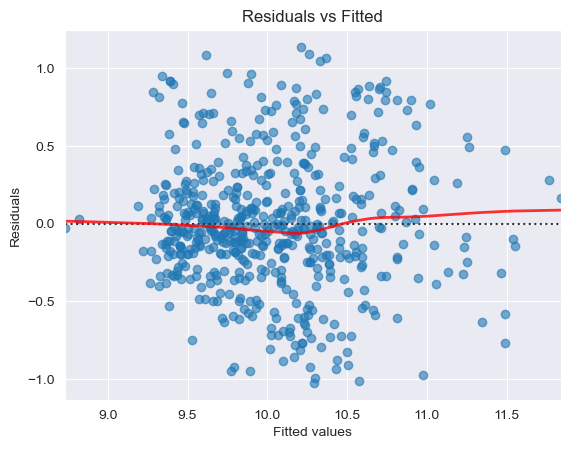

In [37]:
fig_1 = plt.figure(1)
fig_1.axes[0] = sns.residplot(hat_log_price, data['log_price'],
                                  lowess=True,
                                  scatter_kws={'alpha': 0.6},
                                  line_kws={'color': 'red', 'lw': 2, 'alpha': 0.8})
fig_1.axes[0].set_title('Residuals vs Fitted')
fig_1.axes[0].set_xlabel('Fitted values')
fig_1.axes[0].set_ylabel('Residuals')
plt.show()

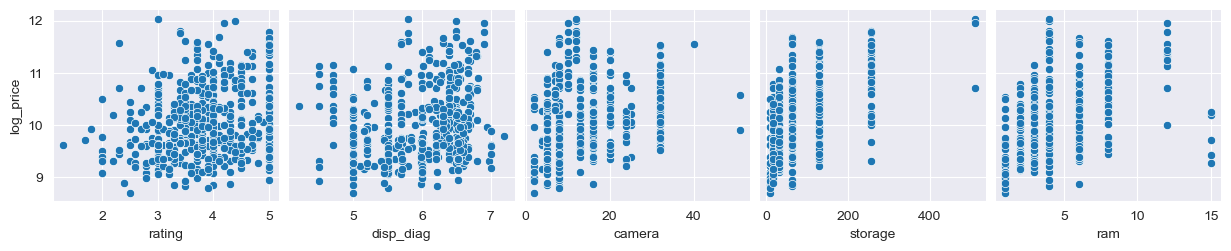

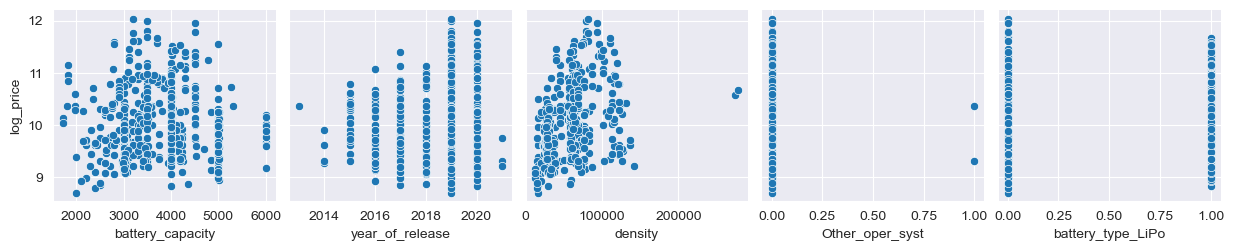

In [38]:
sns.pairplot(data, x_vars=X_columns[0:5], y_vars=["log_price"])
sns.pairplot(data, x_vars=X_columns[5:10], y_vars=["log_price"])
# sns.pairplot(data, x_vars=X_columns[10:15], y_vars=["log_price"]) # Неинтерпретируемые графики
# sns.pairplot(data, x_vars=X_columns[15:20], y_vars=["log_price"]) # Неинтерпретируемые графики
plt.show()

* По графику остатков, можно заметить наличие гетероскедостичности. А так же подтверждает это выведенной распределение данных, к примеру 'rating', ' year of release' и т.д.
* По графику остатков можно заметить, что пропущенно нелинейная связь, что подтверждает наблюдаемая зависимость между остатками и предсказанной целевой пременной.

#### 4.1 Тест на проверку гетероскедостичности <a name="subparagraph4.1"></a>

$$\begin{align}
&H0: \sigma_{i}^2  = \sigma^2, \forall \ i \in \ \{0,1,2,3,4,5\} \ (гомоскедостичность) \\
&H1: \exists \ i, j : \sigma_{i}^2  \neq \sigma_{k}^2 \ (гетероскедостичность)
\end{align}$$

#### 4.1.1 Тест Уйата <a name="subparagraph4.1.1"></a>

In [39]:
X = data.loc[:, X_columns].copy()
y = data['log_price']
model = sm.OLS(y, X).fit()


In [40]:
white_test = het_white(model.resid,  model.model.exog)


In [41]:
labels = ['Chi^2 observed statistic', 'Chi^2 obserrved statistic p-value', 'F-Statistic', 'F-Test p-value']
res_white = dict(zip(labels, white_test))
print(f"Chi^2 observed statistic: {res_white['Chi^2 observed statistic']}")
# print(f"Chi^2 critical Statistics = {sp.stats.chi2.isf(1-0.1, np.shape(model.model.exog)[1] - 1, loc=0)}") Проверить док
print(f"P-value = {res_white['Chi^2 obserrved statistic p-value']}")

Chi^2 observed statistic: 300.16163453579964
P-value = 2.992291924621271e-06


#### 4.1.2 Тест Бройша-Пагана <a name="subparagraph4.1.2"></a>

In [42]:
bp_test = het_breuschpagan(model.resid,  model.model.exog)
labels = ['Chi^2 observed statistic', 'Chi^2 obserrved statistic p-value', 'F-Statistic', 'F-Test p-value']
res_bp = dict(zip(labels, bp_test))
print(f"Chi^2 observed statistic: {res_bp['Chi^2 observed statistic']}")
# print(f"Chi^2 critical Statistics = {sp.stats.chi2.isf(1-0.1, np.shape(model.model.exog)[1] - 1, loc=0)}")  Проверить док
print(f"P-value = {res_bp['Chi^2 obserrved statistic p-value']}")


Chi^2 observed statistic: 265.3694729855122
P-value = 1.595287058035038e-39


#### 4.1.3 Тест Голдфелда — Куандта <a name="subparagraph4.1.3"></a>

In [43]:
goldfeldquandt = het_goldfeldquandt(model.resid,  model.model.exog)
labels = ['F-statistics observed', 'F-statistics p-value', 'ordering']
res_goldfeldquandt = dict(zip(labels, goldfeldquandt))
print(f"F observed statistic: {res_goldfeldquandt['F-statistics observed']}")
print(f"P-value = {res_goldfeldquandt['F-statistics p-value']}")



F observed statistic: 1.1678542687682447
P-value = 0.107975967889056


Относительно Тест Уйата и Бройша-Пагана не отвергается гипотеза о наличии проблемы гетероскедостичности при любом разумном уровне значимости.

### 4.2 Решение проблемы гетероскедостичности <a name="subparagraph3.2"></a>

Для решение этой проблемы воспользуюсь робастными оценками в форме Уайта

##### 4.2.1 Общая информации модели до применение робастных оценок <a name="subparagraph3.2.1"></a>

In [44]:
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.576
Model:                            OLS   Adj. R-squared:                  0.551
Method:                 Least Squares   F-statistic:                     23.06
Date:                Tue, 09 May 2023   Prob (F-statistic):           1.64e-78
Time:                        13:08:00   Log-Likelihood:                -310.10
No. Observations:                 559   AIC:                             684.2
Df Residuals:                     527   BIC:                             822.6
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           -61.2792     40.490     -1.513      0.131    -140.821      18.263
rating                0.0638      0.028      2.302      0.022       0.009       0.118
disp_diag             0.0135      0.067      0.200      0.842      -0.119       0.146
camera                0.0077      0.003      2.767      0.006       0.002       0.013
storage               0.0020      0.000      5.536      0.000       0.001       0.003
ram                   0.0563      0.011      5.029      0.000       0.034       0.078
battery_capacity  -5.432e-05   3.91e-05     -1.390      0.165      -0.000    2.25e-05
year_of_release       0.0349      0.020      1.731      0.084      -0.005       0.074
density            2.516e-06   8.32e-07      3.026      0.003    8.83e-07    4.15e-06
Other_oper_syst       0.2176      0.342      0.636      0.525      -0.454       0.889
battery_type_LiPo     0.0351      0.051      0.689      0.491      -0.065       0.135
brand_Apple           0.9736      0.115      8.449      0.000       0.747       1.200
brand_BlackBerry      0.1798      0.158      1.139      0.255      -0.130       0.490
brand_Cubot           0.3152      0.227      1.386      0.166      -0.132       0.762
brand_Gionee         -0.1408      0.314     -0.449      0.654      -0.757       0.475
brand_Google          0.5760      0.146      3.942      0.000       0.289       0.863
brand_HTC             0.0013      0.097      0.014      0.989      -0.189       0.192
brand_Honor           0.7337      0.202      3.629      0.000       0.337       1.131
brand_Huawei         -0.0384      0.074     -0.519      0.604      -0.184       0.107
brand_Infinix        -0.1524      0.090     -1.686      0.092      -0.330       0.025
brand_LG              0.4522      0.137      3.306      0.001       0.183       0.721
brand_Lava           -0.6389      0.321     -1.991      0.047      -1.269      -0.009
brand_Lenovo         -0.0231      0.144     -0.161      0.872      -0.306       0.259
brand_Motorola        0.6465      0.189      3.415      0.001       0.275       1.018
brand_Nokia          -0.1125      0.112     -1.002      0.317      -0.333       0.108
brand_OnePlus         0.6215      0.125      4.972      0.000       0.376       0.867
brand_Oppo           -0.0341      0.094     -0.363      0.717      -0.219       0.151
brand_Realme         -0.0471      0.116     -0.406      0.685      -0.275       0.181
brand_Samsung         0.1801      0.066      2.737      0.006       0.051       0.309
brand_Sony            0.3684      0.146      2.520      0.012       0.081       0.656
brand_Tecno           0.0388      0.088      0.440      0.660      -0.134       0.212
brand_Vivo            0.1431      0.203      0.705      0.481      -0.255       0.541
=========================================================================

##### 4.2.2 Применение робастных оценок <a name="subparagraph3.2.2"></a>

In [45]:
ols_robust = ols.get_robustcov_results()
ols_robust.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.576
Model:                            OLS   Adj. R-squared:                  0.551
Method:                 Least Squares   F-statistic:                     99.65
Date:                Tue, 09 May 2023   Prob (F-statistic):          2.35e-198
Time:                        13:08:01   Log-Likelihood:                -310.10
No. Observations:                 559   AIC:                             684.2
Df Residuals:                     527   BIC:                             822.6
Df Model:                          31                                         
Covariance Type:                  HC1                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           -61.2792     40.402     -1.517      0.130    -140.649      18.091
rating                0.0638      0.029      2.233      0.026       0.008       0.120
disp_diag             0.0135      0.069      0.196      0.845      -0.122       0.149
camera                0.0077      0.003      2.623      0.009       0.002       0.013
storage               0.0020      0.000      4.480      0.000       0.001       0.003
ram                   0.0563      0.014      4.088      0.000       0.029       0.083
battery_capacity  -5.432e-05   4.03e-05     -1.349      0.178      -0.000    2.48e-05
year_of_release       0.0349      0.020      1.737      0.083      -0.005       0.074
density            2.516e-06   8.24e-07      3.053      0.002    8.97e-07    4.14e-06
Other_oper_syst       0.2176      0.451      0.482      0.630      -0.669       1.104
battery_type_LiPo     0.0351      0.054      0.657      0.512      -0.070       0.140
brand_Apple           0.9736      0.122      7.979      0.000       0.734       1.213
brand_BlackBerry      0.1798      0.216      0.831      0.406      -0.245       0.605
brand_Cubot           0.3152      0.092      3.424      0.001       0.134       0.496
brand_Gionee         -0.1408      0.113     -1.247      0.213      -0.363       0.081
brand_Google          0.5760      0.260      2.219      0.027       0.066       1.086
brand_HTC             0.0013      0.104      0.013      0.990      -0.204       0.207
brand_Honor           0.7337      0.171      4.286      0.000       0.397       1.070
brand_Huawei         -0.0384      0.082     -0.470      0.639      -0.199       0.122
brand_Infinix        -0.1524      0.077     -1.967      0.050      -0.305      -0.000
brand_LG              0.4522      0.154      2.939      0.003       0.150       0.755
brand_Lava           -0.6389      0.096     -6.661      0.000      -0.827      -0.450
brand_Lenovo         -0.0231      0.088     -0.264      0.792      -0.195       0.149
brand_Motorola        0.6465      0.194      3.330      0.001       0.265       1.028
brand_Nokia          -0.1125      0.088     -1.280      0.201      -0.285       0.060
brand_OnePlus         0.6215      0.100      6.199      0.000       0.425       0.818
brand_Oppo           -0.0341      0.095     -0.358      0.720      -0.221       0.153
brand_Realme         -0.0471      0.107     -0.439      0.661      -0.258       0.164
brand_Samsung         0.1801      0.072      2.508      0.012       0.039       0.321
brand_Sony            0.3684      0.154      2.385      0.017       0.065       0.672
brand_Tecno           0.0388      0.088      0.440      0.660      -0.134       0.212
brand_Vivo            0.1431      0.067      2.132      0.033       0.011       0.275
=========================================================================

* brand_Cubot стал значимым на 1% уровне значимост (был незначим на любом разумном уровне значимости)
* brand_Google стал значимым на 5% уровне значимости (был значим на 1% уровне значимости)
* brand_Lava стал значимым на 1% уровне значимости (был значим на 5% уровне значимости)	
* brand_Samsung	значимым на 5% уровне значимости (был значим на 1% уровне значимости)
* brand_Vivo значимым на 5% уровне значимости (был незначим на любом разумном уровне значимости)

### 5. Спецификация модели <a name="subparagraph5"></a>

#### 5.1 Тест Рамсея

In [46]:
rams = reset_ramsey(ols_robust, degree = 2)
print(f"{rams.summary().split(', ')[0][-19:]}")
print(f"{rams.summary().split(', ')[1]}")

F=2.743483985321295
p=0.09824801830562638


In [58]:
# rams = reset_ramsey(ols_robust, degree = 3)
# print(f"{rams.summary().split(', ')[0][-19:]}")
# print(f"{rams.summary().split(', ')[1]}")

In [59]:
# rams = reset_ramsey(ols_robust, degree = 4)
# print(f"{rams.summary().split(', ')[0][-20:]}")
# print(f"{rams.summary().split(', ')[1]}")

* Нулевая гипотеза не отвергается на уровне значимости 5% для второй степени, следовательно гипотеза о том, что модель правильно специфицирована не отвергается. Другими словами, нельзя отвергать гипотезу, что выбранная модель специфицированна правильно.

### 6. Функциональная форма <a name="subparagraph6"></a>

#### 6.1. PE-тест <a name="subparagraph6.1"></a>

In [49]:
Lin_data = data.copy()
Lin_data['price'] = np.exp(Lin_data['log_price'])
Lin_data = Lin_data.drop(columns = ['log_price'])

Log_data = data.copy()

In [50]:
lin_model = sm.OLS(Lin_data['price'], Lin_data.drop(columns = ['price'])).fit()
y_lin_hat = lin_model.predict(Lin_data.drop(columns = ['price']))

In [51]:
log_model = sm.OLS(Log_data['log_price'], Log_data.drop(columns = ['log_price'])).fit()
y_log_hat = log_model.predict(Log_data.drop(columns = ['log_price']))

In [52]:
Lin_data['log_part'] = y_log_hat - np.log(y_lin_hat)
Log_data['lin_part'] = y_lin_hat - np.exp(y_log_hat)

In [53]:
lin_logpart_model = sm.OLS(Lin_data['price'], Lin_data.drop(columns = ['price'])).fit()
lin_logpart_model = lin_logpart_model.get_robustcov_results()

log_linpart_model = sm.OLS(Log_data['log_price'], Log_data.drop(columns = ['log_price'])).fit()
log_linpart_model = log_linpart_model.get_robustcov_results()


In [54]:
# print(f"P-value log_part in lin_logpart_model = {lin_logpart_model.pvalues['log_part']}") # sigma_lin
# print(f"P-value lin_part in log_linpart_model = {log_linpart_model.pvalues['lin_part']}") # sigma_log

In [55]:
print(f"P-value log_part in lin_logpart_model = {lin_logpart_model.pvalues[-1]}") # sigma_lin
print(f"P-value lin_part in log_linpart_model = {log_linpart_model.pvalues[-1]}") # sigma_log

P-value log_part in lin_logpart_model = 1.5534431157386094e-07
P-value lin_part in log_linpart_model = 0.5205516907761274


На любом разумном уровне значимости нулевая гипотеза о незначимости логорифмической части в линейной модели отвергается, то есть sigma_lin значим. В то же время значимость линейней части в полулогорифмической модели отвергается при любом разумном уровне значимости, то есть не отвергается гипотеза, что sigma_log = 0. Другими словами, линейная часть в полулогорифмической модели не позволила лучше объяснить данные, в то время как логорифмическая чать в линейной модели показало значимый результат.

Следовательно относительно PE-теста необходимо выбрать полулогорифмическую модель.

#### 6.2 Проверка нормальности остатков (Тест Харке-Бера) <a name="subparagraph6.2"></a>

In [56]:
_, p_value = stats.jarque_bera(ols_robust.resid)
print(f"Тест Харке-Бера p_value = {p_value}") #

Тест Харке-Бера p_value = 0.0750218329565121


На 5% уровне значимости нулевая гипотеза, что остатки имеют нормальное распределение, не отвергается. Следовательно, так как остатки являются оценкой ошибок, то нельзя отвергаеть гипотезу, что выполняется предпосылка КЛММР о стадартном нормальном распределении ошибок.

In [57]:
data.to_csv('PhonesDF_years_corrected_v2.csv', index=False)